In [2]:
import numpy as np
from tensorflow.python.ops.numpy_ops.np_dtypes import int64
import matplotlib.pyplot as plt
import time
from tensorflow.python.types.doc_typealias import document
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays


## generating data sets
this code will take 2 params, the number of samples and the number of features and the code will generate the data sets randomly

In [64]:
def generate_realistic_dataset(num_samples=100, n_features=10):
    """
    Generates a synthetic dataset with realistic relationships between features and target.

    Args:
        num_samples (int): Number of data points to generate.
        n_features (int): Number of features in the dataset.

    Returns:
        X_train (ndarray): Feature matrix of shape (num_samples, n_features).
        y_train (ndarray): Target array of shape (num_samples,).
    """
    # Initialize the feature matrix
    X_train = np.zeros((num_samples, n_features), dtype=int)

    # Populate features dynamically with realistic correlations
    for i in range(n_features):
        if i == 0:  # Feature 1: Area in square feet
            X_train[:, i] = np.random.randint(800, 4000, num_samples)
        elif i == 1:  # Feature 2: Bedrooms (correlated with area)
            X_train[:, i] = np.clip((X_train[:, 0] // 1000) + np.random.randint(-1, 2, num_samples), 1, 6)
        elif i == 2:  # Feature 3: Bathrooms (slightly less correlated than bedrooms)
            X_train[:, i] = np.clip((X_train[:, 1] // 2) + np.random.randint(0, 2, num_samples), 1, 4)
        elif i == 3:  # Feature 4: Age of property
            X_train[:, i] = np.random.randint(1, 100, num_samples)  # Wider range for realism
        elif i == 4:  # Feature 5: Distance to city center (in km)
            X_train[:, i] = np.random.randint(1, 50, num_samples)
        elif i == 5:  # Feature 6: Number of floors
            X_train[:, i] = np.random.randint(1, 4, num_samples)
        elif i == 6:  # Feature 7: Lot size (in square meters)
            X_train[:, i] = np.random.randint(500, 2000, num_samples)
        elif i == 7:  # Feature 8: Year built
            X_train[:, i] = 2024 - np.random.randint(1, 100, num_samples)
        else:  # Additional features: Random values within a defined range
            X_train[:, i] = np.random.randint(1, 100, num_samples)

    # Generate labels (house prices) based on feature weights and added noise
    coefficients = np.array([100, 50, 30, -20, -5, 10, 40, 15] + [5] * (n_features - 8))  # Feature weights
    noise = np.random.normal(0, 5000, num_samples)  # Add realistic noise
    y_train = (X_train @ coefficients[:n_features] + noise).astype(int)

    return X_train, y_train

<a name="toc_15456_3"></a>
## Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

In [4]:
def predict(W,b,X_record):
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    return np.dot(X_record,W) + b

<a name="toc_15456_4"></a>
# Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [5]:
def J(W,b,X,y):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    #iterative code
    m = X.shape[0]
    # c = 0.0
    # for i in range(m):
    #     f_wb_i = np.dot(W,X[i]) + b
    #     c += (f_wb_i - y[i])**2
    # c= c/2*m
    
    #numpy code
    
    #it will iterate over the rows of X and dot it by W and add the b and then it will be stored in f_wb[i]and that's for every row of X  
    F_WB = np.dot(X,W) + b
    Squared_Error = (F_WB  - y) ** 2
    c = np.sum(Squared_Error)/(2*m) 
    #+ (lambaa * np.sum(W ** 2) / (2*m))
    
    return c

<a name="toc_15456_5"></a>
## 5 Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


### Dot Product Explanation

The dot product will return an array, where each element contains the dot product of a record (row) with the weights vector.

#### Example
Consider the following table with 4 features and \(m\) records:

| Feature 1 | Feature 2 | Feature 3 | Feature 4 | Target (y) |
|-----------|-----------|-----------|-----------|------------|
| 10        | 20        | 30        | 40        | 203        |
| ..        | ..        | ..        | ..        | ...        |

and the weights of features

| W of Feature 1 | W of Feature 2 | W of Feature 3 | W of Feature 4 |
|----------------|----------------|----------------|----------------|
| 1              | 0.1            | 2              | -22            | 

#### Dot Product Computation:
the dot product will return an array with m elements [x[i] . w[i], ... ] 
or [ [10,20,30,40] . [1,0.1,2,-22] , ... ]

In [6]:

def partial_derivative(W,b,X,y):
    """
    Compute the partial derivatives of the cost function with respect to W and b.

    Args:
      W (ndarray (n,)): Model parameters (weights)
      b (scalar): Model parameter (bias)
      X (ndarray (m, n)): Input data (m records, n features)
      y (ndarray (m,)): Target values

    Returns:
      DJ_DW (ndarray (n,)): Partial derivatives with respect to W
      dj_db (scalar): Partial derivative with respect to b
    """
    number_of_features = n = X.shape[1]
    number_of_records = m = X.shape[0]
    DJ_DW = np.zeros(number_of_features)
    dj_db = 0.0
    errors = np.dot(X,W) + b - y         #the error for every record
    dj_db = np.sum(errors)/m  
    for j in range(number_of_features):
        DJ_DW[j] = (np.sum(errors * X[:,j]))/m
    return DJ_DW, dj_db


## scaling the features

In [7]:
def max_scaling(x):
    """
    Args:
        x (ndarray (m,n)): Input data (m records, n features)
    """
    mx = x.max(axis=0) #get the max for each column, for each feature specifically
    return x / mx #divide each column by correspondant element of mx

def mean_normalization(x):
    """
    Args:
        x (ndarray (m,n)): Input data (m records, n features)
    """
    mean = x.mean(axis=0)
    mx = x.max(axis=0)
    mn = x.min(axis=0)
    return (x - mean) / mx

def z_scoring(x):
    """
    Args:
        x (ndarray (m,n)): Input data (m records, n features)
    """
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    return (x - mean) / std

### now into gradient descent code

In [61]:
def gradient_descent(Init_W,init_b,alpha,times,X_Training,y_training): 
     
    """
    Perform gradient descent optimization to find optimal model parameters.
    
    This function iteratively updates weights (W) and bias (b) to minimize 
    the cost function using gradient descent algorithm.
    
    Args:
        Init_W (numpy.ndarray): Initial weights vector 
            Shape: (number_of_features,)
        init_b (float): Initial bias value
        alpha (float): Learning rate controlling step size of parameter updates
        times (int): Maximum number of iterations to perform
        X_Training (numpy.ndarray): Training feature matrix 
            Shape: (number_of_samples, number_of_features)
        y_training (numpy.ndarray): Training target values 
            Shape: (number_of_samples,)
    
    Returns:
        tuple: 
            - W (numpy.ndarray): Optimized weights vector
            - b (float): Optimized bias value
    """
    
    x_axis = []
    y_axis = []
    W = Init_W
    number_of_features = n = W.shape[0]
    b = init_b
    for i in range(times):
        DJ_DW,dj_db = partial_derivative(W,b,X_Training,y_training)
        b = b - alpha*dj_db        
        W = W - DJ_DW * alpha
        x_axis.append(i)
        cost = J(W,b,X_Training,y_training)
        y_axis.append(cost)
        if(cost < 1e-10):
            print(i)
            break
    plt.plot(x_axis,y_axis)
    return W,b


def gradient_descent_algorithm(X_Training,y_training):
    """
    Prepare and execute gradient descent optimization.
    
    Sets up initial parameters and calls gradient descent function.
    
    Args:
        X_Training (numpy.ndarray): Training feature matrix 
            Shape: (number_of_samples, number_of_features)
        y_training (numpy.ndarray): Training target values 
            Shape: (number_of_samples,)
    
    Returns:
        tuple: 
            - W (numpy.ndarray): Optimized weights vector
            - b (float): Optimized bias value
    
    Configuration:
        - Initial weights set to zero
        - Initial bias set to 0.0
        - Learning rate (alpha) set to 5.0e-8
        - Maximum iterations set to 10,000
    """
    number_of_features = X_Training.shape[1]
    Init_W = np.full(number_of_features,0)
    init_b = 0.
    alpha = 5.0e-1 #if you normalize data you must choose smaller learning rate
    times = 100000
    return gradient_descent(Init_W,init_b,alpha,times,X_Training,y_training)
        

## Running the Code and taking Predication

the cost now is: 485067.3952568118
the Weights are:  [ 4.71e+04 -2.48e+01  8.78e+01 -2.08e+02]
the bias is: 123310.15
204928.14192023396


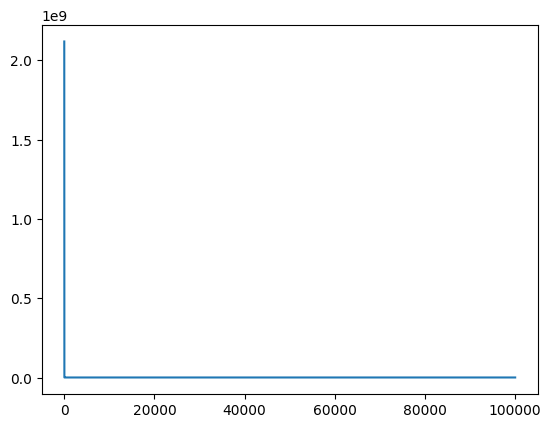

In [65]:
num_samples = 100 ; num_features = 4

x_train, y_train = generate_dataset(num_samples,num_features)
#x_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
#y_train = np.array([460, 232, 178])

x_train = z_scoring(x_train)

W,b = gradient_descent_algorithm(x_train,y_train)

x_sample = np.array([1000,2,3,4])
x_sample = z_scoring(x_sample)
print(f"the cost now is: {J(W,b,x_train,y_train)}")

print("the Weights are: ",W)
print(f"the bias is: {b:0.2f}")
print(predict(W,b,x_sample))



## some visualization

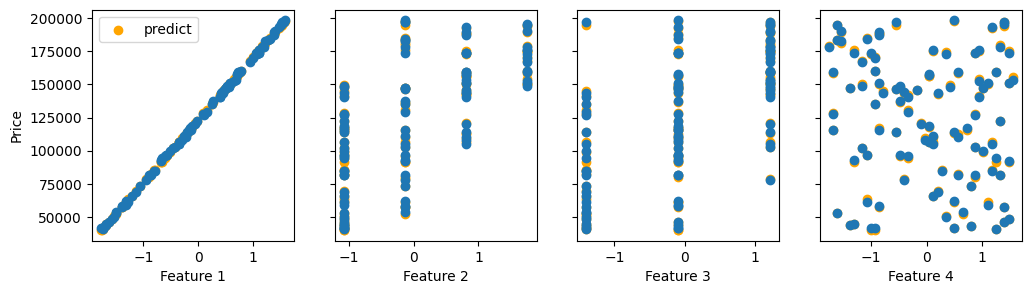

In [66]:
fig, ax = plt.subplots(1,4,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(x_train[:,i],predict(W,b,x_train),color='orange', label = 'predict')
    ax[i].scatter(x_train[:,i],y_train)
    ax[i].set_xlabel(f"Feature {i+1}")
ax[0].set_ylabel("Price"); ax[0].legend();


    